# IQ sampling

This notebook presents IQ sampling techique

First, let us make sure that all dependencies are installed

In [1]:
!pip install numpy matplotlib scipy

Next, let us import these dependencies

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter

## Regular sampling

Finally, let us generate a signal with five CW tones

In [3]:
n = 5
N = 16384
fs = 1000
spectral_resolution = fs / N
f = np.array([np.arange(1, n + 1) * spectral_resolution * 1000])
fmin = np.min(f)
fmax = np.max(f)
assert fmax <= fs / 2, f'f_max = {fmax} above f_s / 2 = {fs / 2}'
t = np.arange(0, 4 * np.pi, 1 / fs)
x = np.sin(2 * np.pi * np.dot(np.transpose(f), np.array([t])))
x = np.sum(x, axis = 0)

It is time to compute double-sided FFT of the generated signal and plot it

<StemContainer object of 3 artists>

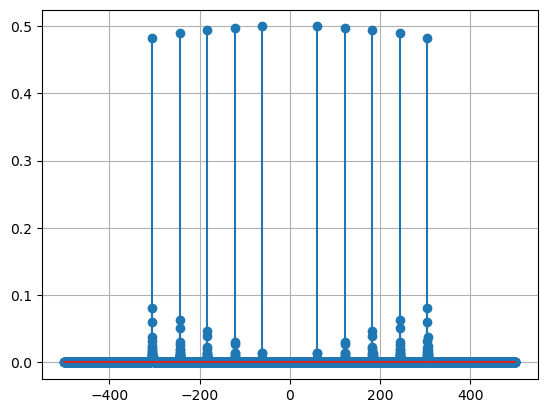

In [4]:
X = np.fft.fftshift(np.fft.fft(x))
freqs = np.fft.fftshift(np.fft.fftfreq(len(X), 1 / fs))
magnitude = np.abs(X) / len(X)

plt.figure()
plt.grid()
plt.stem(freqs, magnitude)

As you can see above, we got twice as many peaks as expected. Furthermore, each peak has half of the expected magnitude. This is because the regular sampling does not preserve phase content.

## IQ sampling

Now, let us sample the generated signal using IQ technique

In [5]:
fc = (fmax + fmin) / 2
x_i = x * np.cos(2 * np.pi * fc * t)
x_q = -x * np.sin(2 * np.pi * fc * t)

fcutoff = fmax - fc + 100
print(f'fc = {fc}, fmin = {fmin}, fmax = {fmax}, fcutoff = {fcutoff}')
numtaps = 101
coeffs = firwin(numtaps, fcutoff, fs = fs)

x_i = lfilter(coeffs, 1.0, x_i)
x_q = lfilter(coeffs, 1.0, x_q)

x = x_i + 1.0j * x_q

fc = 183.10546875, fmin = 61.03515625, fmax = 305.17578125, fcutoff = 222.0703125


Recompute the double-sided FFT

<StemContainer object of 3 artists>

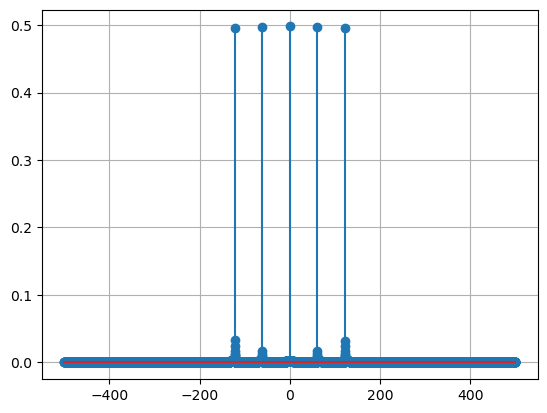

In [6]:
X = np.fft.fftshift(np.fft.fft(x))
magnitude = np.abs(X) / len(X)

plt.figure()
plt.grid()
plt.stem(freqs, magnitude)

After IQ sampling, we got five peaks. However, the magnitude was still half of the expected. This is because how the maths behind IQ sampling works. Long story short, sine function can be expressed as $$sin(\phi) = \frac{1}{2j}(e^{j\phi} - e^{-j\phi})$$

IQ sampling gets rid of the second exponential term (hence the number of peaks matches our expectations), but not 1/2 term in the very beginning of that expression. Therefore magnitude is halved.